In [48]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from IPython.display import Image

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator

import pandas as pd
import numpy as np

import os
import random
import warnings
import networkx as nx
from scipy.io import arff
import matplotlib.pyplot as plt
import pgmpy.estimators as ests
from pgmpy.estimators import TreeSearch
from pgmpy.metrics import structure_score
from sklearn.metrics import accuracy_score
from pgmpy.inference import BeliefPropagation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt

%matplotlib inline



In [50]:
#Image(filename='modelo.png')

# Parte 1 : Definicion Manual

In [131]:
# Definir el modelo Bayesian Network
model = BayesianNetwork([('CLIENTE', 'SINIESTROS'),('USO_VEHICULO','INFRACCIONES'),('INFRACCIONES','PRIMA_TECNICA'),('SINIESTROS','PRIMA_TECNICA'),('CATEGORIA_VEHICULO','PRIMA_TECNICA'),('GENERO','EDAD_CONDUCTOR'),('EDAD_CONDUCTOR','PRIMA_TECNICA'),('RIESGO_UBICACION','PRIMA_TECNICA')])


In [132]:

# Definir las distribuciones de probabilidad condicional (CPDs)
cpd_cliente = TabularCPD('CLIENTE', 2, [[0.3], [0.7]],state_names={'CLIENTE': ['NUEVO', 'ANTIGUO']})
cpd_siniestros = TabularCPD('SINIESTROS', 2, [[0, 0.3], [1, 0.7]], evidence=['CLIENTE'], evidence_card=[2],state_names={'SINIESTROS': ['SI', 'NO'], 'CLIENTE': ['NUEVO', 'ANTIGUO']})
cpd_uso_vehiculo = TabularCPD('USO_VEHICULO', 2, [[0.6], [0.4]],state_names={'USO_VEHICULO': ['PARTICULAR', 'COMERCIAL']})
cpd_infracciones = TabularCPD('INFRACCIONES', 2, [[0.3, 0.1], [0.7, 0.9]], evidence=['USO_VEHICULO'], evidence_card=[2],state_names={'INFRACCIONES': ['NO', 'SI'], 'USO_VEHICULO': ['PARTICULAR', 'COMERCIAL']})
cpd_riesgo_ubicacion = TabularCPD('RIESGO_UBICACION', 2, [[0.55], [0.45]],state_names={'RIESGO_UBICACION': ['ALTO', 'BAJO']})
cpd_genero = TabularCPD('GENERO',2, [[0.6],[0.4]],state_names={'GENERO': ['MASCULINO', 'FEMENINO']})
cpd_edad_conductor = TabularCPD('EDAD_CONDUCTOR',2,[[0.09,0.10],[0.91,0.90]],evidence =['GENERO'], evidence_card = [2],state_names={'EDAD_CONDUCTOR': ['JOVEN', 'ADULTO'],'GENERO': ['MASCULINO', 'FEMENINO']})
cpd_categoria_vehiculo = TabularCPD('CATEGORIA_VEHICULO',2,[[0.3],[0.7]],state_names={'CATEGORIA_VEHICULO': ['GAMA ALTA', 'GAMA BAJA']})
cpd_prima_tecnica = TabularCPD('PRIMA_TECNICA',2,[[0.6,0.6,0.5,0.5,0.6,0.6,0.5,0.5,0.4,0.3,0.8,0.9,0.5,0.4,0.8,0.9,0.3,0.4,0.4,0.5,0.3,0.4,0.4,0.5,0.6,0.7,0.2,0.2,0.6,0.6,0.2,0.2],
                                                 [0.4,0.4,0.5,0.5,0.4,0.4,0.5,0.5,0.6,0.7,0.2,0.1,0.5,0.6,0.2,0.1,0.7,0.6,0.6,0.5,0.7,0.6,0.6,0.5,0.4,0.3,0.8,0.8,0.4,0.4,0.8,0.8]
                                                  ],
                               evidence = ['SINIESTROS','CATEGORIA_VEHICULO','INFRACCIONES','EDAD_CONDUCTOR','RIESGO_UBICACION'],
                               evidence_card = [2,2,2,2,2],
                               state_names={'PRIMA_TECNICA': ['ALTO', 'BAJO'],
                                            'SINIESTROS': ['SI', 'NO'],
                                            'CATEGORIA_VEHICULO': ['GAMA ALTA', 'GAMA BAJA'],
                                            'INFRACCIONES': ['NO', 'SI'],
                                            'EDAD_CONDUCTOR': ['JOVEN', 'ADULTO'],
                                            'RIESGO_UBICACION': ['ALTO', 'BAJO']})


In [133]:

# Asociar las CPDs al modelo
model.add_cpds(cpd_cliente, cpd_siniestros,cpd_uso_vehiculo,cpd_infracciones,cpd_prima_tecnica,cpd_riesgo_ubicacion,cpd_genero,cpd_edad_conductor,cpd_categoria_vehiculo)

In [134]:
model.check_model()

True

In [135]:
print(model.get_cpds('CLIENTE'))

+------------------+-----+
| CLIENTE(NUEVO)   | 0.3 |
+------------------+-----+
| CLIENTE(ANTIGUO) | 0.7 |
+------------------+-----+


In [136]:
print(model.get_cpds('USO_VEHICULO'))

+--------------------------+-----+
| USO_VEHICULO(PARTICULAR) | 0.6 |
+--------------------------+-----+
| USO_VEHICULO(COMERCIAL)  | 0.4 |
+--------------------------+-----+


In [137]:
print(model.get_cpds('RIESGO_UBICACION'))

+------------------------+------+
| RIESGO_UBICACION(ALTO) | 0.55 |
+------------------------+------+
| RIESGO_UBICACION(BAJO) | 0.45 |
+------------------------+------+


In [138]:
print(model.get_cpds('GENERO'))

+-------------------+-----+
| GENERO(MASCULINO) | 0.6 |
+-------------------+-----+
| GENERO(FEMENINO)  | 0.4 |
+-------------------+-----+


In [139]:
print(model.get_cpds('CATEGORIA_VEHICULO'))

+-------------------------------+-----+
| CATEGORIA_VEHICULO(GAMA ALTA) | 0.3 |
+-------------------------------+-----+
| CATEGORIA_VEHICULO(GAMA BAJA) | 0.7 |
+-------------------------------+-----+


In [140]:
print(model.get_cpds('SINIESTROS'))

+----------------+----------------+------------------+
| CLIENTE        | CLIENTE(NUEVO) | CLIENTE(ANTIGUO) |
+----------------+----------------+------------------+
| SINIESTROS(SI) | 0.0            | 0.3              |
+----------------+----------------+------------------+
| SINIESTROS(NO) | 1.0            | 0.7              |
+----------------+----------------+------------------+


In [141]:
print(model.get_cpds('EDAD_CONDUCTOR'))

+------------------------+-------------------+------------------+
| GENERO                 | GENERO(MASCULINO) | GENERO(FEMENINO) |
+------------------------+-------------------+------------------+
| EDAD_CONDUCTOR(JOVEN)  | 0.09              | 0.1              |
+------------------------+-------------------+------------------+
| EDAD_CONDUCTOR(ADULTO) | 0.91              | 0.9              |
+------------------------+-------------------+------------------+


In [142]:
print(model.get_cpds('INFRACCIONES'))

+------------------+--------------------------+-------------------------+
| USO_VEHICULO     | USO_VEHICULO(PARTICULAR) | USO_VEHICULO(COMERCIAL) |
+------------------+--------------------------+-------------------------+
| INFRACCIONES(NO) | 0.3                      | 0.1                     |
+------------------+--------------------------+-------------------------+
| INFRACCIONES(SI) | 0.7                      | 0.9                     |
+------------------+--------------------------+-------------------------+


In [143]:
print(model.get_cpds('PRIMA_TECNICA')) #.values[1][0][1][0][1])

+---------------------+-----+-------------------------------+
| SINIESTROS          | ... | SINIESTROS(NO)                |
+---------------------+-----+-------------------------------+
| CATEGORIA_VEHICULO  | ... | CATEGORIA_VEHICULO(GAMA BAJA) |
+---------------------+-----+-------------------------------+
| INFRACCIONES        | ... | INFRACCIONES(SI)              |
+---------------------+-----+-------------------------------+
| EDAD_CONDUCTOR      | ... | EDAD_CONDUCTOR(ADULTO)        |
+---------------------+-----+-------------------------------+
| RIESGO_UBICACION    | ... | RIESGO_UBICACION(BAJO)        |
+---------------------+-----+-------------------------------+
| PRIMA_TECNICA(ALTO) | ... | 0.2                           |
+---------------------+-----+-------------------------------+
| PRIMA_TECNICA(BAJO) | ... | 0.8                           |
+---------------------+-----+-------------------------------+


# Inferencias

In [147]:
infer = VariableElimination(model)

In [148]:
#Cual es la probabilidad de que un adulto mujer tenga un vehiculo de alta gama
q = infer.query(variables=["CATEGORIA_VEHICULO"], evidence={"GENERO": 'FEMENINO',"EDAD_CONDUCTOR": 'ADULTO' })
print(q)

+-------------------------------+---------------------------+
| CATEGORIA_VEHICULO            |   phi(CATEGORIA_VEHICULO) |
+===============================+===========================+
| CATEGORIA_VEHICULO(GAMA ALTA) |                    0.3000 |
+-------------------------------+---------------------------+
| CATEGORIA_VEHICULO(GAMA BAJA) |                    0.7000 |
+-------------------------------+---------------------------+


In [149]:
#Cual es la probabilidad de que los hombres jovenes tengan alta cantidad de infracciones?
q = infer.query(variables=["INFRACCIONES"], evidence={"GENERO": 'MASCULINO', "EDAD_CONDUCTOR": 'JOVEN'})
print(q)

+------------------+---------------------+
| INFRACCIONES     |   phi(INFRACCIONES) |
+==================+=====================+
| INFRACCIONES(NO) |              0.2200 |
+------------------+---------------------+
| INFRACCIONES(SI) |              0.7800 |
+------------------+---------------------+


In [150]:
#Cual es la probabilidad de que una persona con edad adulta viva en un lugar de bajos riesgos?
q = infer.query(variables=["RIESGO_UBICACION"], evidence={"EDAD_CONDUCTOR": 'ADULTO'})
print(q)

+------------------------+-------------------------+
| RIESGO_UBICACION       |   phi(RIESGO_UBICACION) |
+========================+=========================+
| RIESGO_UBICACION(ALTO) |                  0.5500 |
+------------------------+-------------------------+
| RIESGO_UBICACION(BAJO) |                  0.4500 |
+------------------------+-------------------------+


In [151]:
#Cual es la probabilidad de que las mujeres adultas no tengan siniestros anteriores?
q = infer.query(variables=["SINIESTROS"], evidence={"GENERO": 'FEMENINO',"EDAD_CONDUCTOR": 'ADULTO'} )
print(q)

+----------------+-------------------+
| SINIESTROS     |   phi(SINIESTROS) |
+================+===================+
| SINIESTROS(SI) |            0.2100 |
+----------------+-------------------+
| SINIESTROS(NO) |            0.7900 |
+----------------+-------------------+


In [152]:
#Cual es la probabilidad de tener clientes jovenes nuevos?
q = infer.query(variables=["EDAD_CONDUCTOR"] )
print(q)

+------------------------+-----------------------+
| EDAD_CONDUCTOR         |   phi(EDAD_CONDUCTOR) |
+========================+=======================+
| EDAD_CONDUCTOR(JOVEN)  |                0.0940 |
+------------------------+-----------------------+
| EDAD_CONDUCTOR(ADULTO) |                0.9060 |
+------------------------+-----------------------+


# Carga de la data de Seguros Vehiculares

In [153]:
df_pre = pd.read_excel('SEGUROS VEHICULARES.xlsx')

In [154]:
df=df_pre

In [155]:
df.head()

,CATEGORIA_VEHICULO,NIVEL_EDUCACION,INGREOS_ASEGURADO,FLAG_CLIENTE_NUEVO,USO_VEHICULO,FLAG_SINIESTROS_ANTERIORES,Q_INFRACCIONES,GENERO_ASEGURADO,EDAD_ASEGURADO,UBICACIÓN,PRIMA
0,0,NaN,NaN,0,PARTICULAR,0,NaN,NO APLICA,32.0,D2,374.07
1,0,NaN,NaN,1,PARTICULAR,0,NaN,MASCULINO,49.0,L2,752.91
2,0,NaN,NaN,1,PARTICULAR,0,NaN,MASCULINO,28.0,L1,566.40
3,0,NaN,NaN,0,PARTICULAR,0,NaN,MASCULINO,49.0,L7,1659.54
4,0,NaN,NaN,0,PARTICULAR,1,1.0,MASCULINO,44.0,D4,471.76


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737002 entries, 0 to 737001
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CATEGORIA_VEHICULO          737002 non-null  int64  
 1   NIVEL_EDUCACION             0 non-null       float64
 2   INGREOS_ASEGURADO           0 non-null       float64
 3   FLAG_CLIENTE_NUEVO          737002 non-null  int64  
 4   USO_VEHICULO                736997 non-null  object 
 5   FLAG_SINIESTROS_ANTERIORES  737002 non-null  int64  
 6   Q_INFRACCIONES              121751 non-null  float64
 7   GENERO_ASEGURADO            736828 non-null  object 
 8   EDAD_ASEGURADO              736828 non-null  float64
 9   UBICACIÓN                   736828 non-null  object 
 10  PRIMA                       737002 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 61.9+ MB


In [157]:
df= df.drop(['NIVEL_EDUCACION', 'INGREOS_ASEGURADO'], axis=1)

In [158]:
df.rename(columns={'FLAG_CLIENTE_NUEVO': 'CLIENTE',
                   'FLAG_SINIESTROS_ANTERIORES': 'SINIESTROS',
                   'GENERO_ASEGURADO': 'GENERO' ,
                   'EDAD_ASEGURADO':'EDAD_CONDUCTOR',
                   'UBICACIÓN':'RIESGO_UBICACION',
                   'Q_INFRACCIONES': 'INFRACCIONES',
                   'PRIMA': 'PRIMA_TECNICA'}, inplace=True)


In [159]:
for columna in df.columns:
    valores_unicos = df[columna].unique()
    print(f"Valores únicos de la columna '{columna}':")
    print(valores_unicos)
    print()

Valores únicos de la columna 'CATEGORIA_VEHICULO':
[0 1]

Valores únicos de la columna 'CLIENTE':
[0 1]

Valores únicos de la columna 'USO_VEHICULO':
['PARTICULAR' 'COMERCIAL' 'PUBLICO URBANO' 'CARGA' 'TURISMO' 'ALQUILER'
 'TAXI' 'POLICIAL' 'AMBULANCIA' nan 'OTRO' 'PUBLICO NACIONAL']

Valores únicos de la columna 'SINIESTROS':
[0 1]

Valores únicos de la columna 'INFRACCIONES':
[nan  1.  3.  2.  4.  5.  6.  8.  7.]

Valores únicos de la columna 'GENERO':
['NO APLICA' 'MASCULINO' 'FEMENINO' nan]

Valores únicos de la columna 'EDAD_CONDUCTOR':
[ 32.  49.  28.  44.  48.  40.  69.  45.  54.  41.  57.  64.  74.  39.
  43.  53.  61.  27.  46.  50.  37.  71.  51.  66.  33.  35.  63.  42.
  60.  77.  36.  73.  34.  76.  29.  67.  38.  68.  47.  56.  62.  31.
  59.  58.  23.  24.  70.  30.  52.  55.  75.  72.  21.  25.  81.  nan
  65.  26.  79.  84.  83.  87.  22.  78.  88.  20.  86.  80.  85.  19.
  82.  92.  18.  93.   0.  90.  89.  91.  96.   4.   3.  95. 114.  94.
 115.  17. 100.  15.  13. 

In [160]:
df['CATEGORIA_VEHICULO'].replace({0: 'GAMA ALTA', 1: 'GAMA BAJA'}, inplace=True)

In [161]:
df['CLIENTE'].replace({0: 'NUEVO', 1: 'ANTIGUO'}, inplace=True)

In [162]:
filtro = (df['USO_VEHICULO'] == 'PARTICULAR') | (df['USO_VEHICULO'] == 'COMERCIAL')
df = df[filtro]

In [163]:
df['SINIESTROS'].replace({0: 'SI', 1: 'NO'}, inplace=True)

In [164]:
df['INFRACCIONES'] = df['INFRACCIONES'].fillna('NO')
df['INFRACCIONES'] = df['INFRACCIONES'].map(lambda x: 'SI' if isinstance(x, (int, float)) else x)

In [165]:
filtro = (df['GENERO'] == 'FEMENINO') | (df['GENERO'] == 'MASCULINO')
df = df[filtro]

In [166]:
df['EDAD_CONDUCTOR'] = np.where(df['EDAD_CONDUCTOR'] > 30, 'ADULTO', 'JOVEN')

In [167]:
df['RIESGO_UBICACION'].replace({'L1': 'ALTO', 'L2': 'ALTO','L3': 'BAJO', 'L4':'BAJO', 'L5':'ALTO', 'L6':'ALTO', 'L7': 'ALTO'}, inplace=True)
filtro = (df['RIESGO_UBICACION'] == 'ALTO') | (df['RIESGO_UBICACION'] == 'BAJO')
df = df[filtro]

In [168]:
valores = ['BAJO', 'ALTO']
#df['PRIMA_TECNICA'] = np.random.choice(valores, size=len(df))
df['PRIMA_TECNICA'] = np.where(df['PRIMA_TECNICA'] > 580, 'ALTO', 'BAJO')


# Parte 2: Aprendizaje de Parámetros

In [169]:
for columna in df.columns:
    valores_unicos = df[columna].unique()
    print(f"Valores únicos de la columna '{columna}':")
    print(valores_unicos)
    print()

Valores únicos de la columna 'CATEGORIA_VEHICULO':
['GAMA ALTA' 'GAMA BAJA']

Valores únicos de la columna 'CLIENTE':
['ANTIGUO' 'NUEVO']

Valores únicos de la columna 'USO_VEHICULO':
['PARTICULAR' 'COMERCIAL']

Valores únicos de la columna 'SINIESTROS':
['SI' 'NO']

Valores únicos de la columna 'INFRACCIONES':
['NO' 'SI']

Valores únicos de la columna 'GENERO':
['MASCULINO' 'FEMENINO']

Valores únicos de la columna 'EDAD_CONDUCTOR':
['ADULTO' 'JOVEN']

Valores únicos de la columna 'RIESGO_UBICACION':
['ALTO' 'BAJO']

Valores únicos de la columna 'PRIMA_TECNICA':
['ALTO' 'BAJO']



In [170]:
df.head()

,CATEGORIA_VEHICULO,CLIENTE,USO_VEHICULO,SINIESTROS,INFRACCIONES,GENERO,EDAD_CONDUCTOR,RIESGO_UBICACION,PRIMA_TECNICA
1,GAMA ALTA,ANTIGUO,PARTICULAR,SI,NO,MASCULINO,ADULTO,ALTO,ALTO
2,GAMA ALTA,ANTIGUO,PARTICULAR,SI,NO,MASCULINO,JOVEN,ALTO,BAJO
3,GAMA ALTA,NUEVO,PARTICULAR,SI,NO,MASCULINO,ADULTO,ALTO,ALTO
5,GAMA ALTA,ANTIGUO,PARTICULAR,SI,NO,FEMENINO,ADULTO,BAJO,BAJO
8,GAMA ALTA,NUEVO,PARTICULAR,SI,NO,MASCULINO,ADULTO,BAJO,BAJO


In [171]:
df.isnull().sum(axis=0)

CATEGORIA_VEHICULO    0
CLIENTE               0
USO_VEHICULO          0
SINIESTROS            0
INFRACCIONES          0
GENERO                0
EDAD_CONDUCTOR        0
RIESGO_UBICACION      0
PRIMA_TECNICA         0
dtype: int64

In [172]:
mle = MaximumLikelihoodEstimator(model, df)

In [173]:
print(mle.estimate_cpd('CLIENTE'))


+------------------+----------+
| CLIENTE(ANTIGUO) | 0.422999 |
+------------------+----------+
| CLIENTE(NUEVO)   | 0.577001 |
+------------------+----------+


In [174]:
print(mle.estimate_cpd('SINIESTROS'))


+----------------+---------------------+---------------------+
| CLIENTE        | CLIENTE(ANTIGUO)    | CLIENTE(NUEVO)      |
+----------------+---------------------+---------------------+
| SINIESTROS(NO) | 0.18813923506660937 | 0.14753538408478917 |
+----------------+---------------------+---------------------+
| SINIESTROS(SI) | 0.8118607649333907  | 0.8524646159152108  |
+----------------+---------------------+---------------------+


In [175]:
print(mle.estimate_cpd('USO_VEHICULO'))


+--------------------------+------------+
| USO_VEHICULO(COMERCIAL)  | 0.00422301 |
+--------------------------+------------+
| USO_VEHICULO(PARTICULAR) | 0.995777   |
+--------------------------+------------+


In [176]:
print(mle.estimate_cpd('INFRACCIONES'))


+------------------+-------------------------+--------------------------+
| USO_VEHICULO     | USO_VEHICULO(COMERCIAL) | USO_VEHICULO(PARTICULAR) |
+------------------+-------------------------+--------------------------+
| INFRACCIONES(NO) | 0.8889895786135025      | 0.8350614712359197       |
+------------------+-------------------------+--------------------------+
| INFRACCIONES(SI) | 0.11101042138649751     | 0.16493852876408036      |
+------------------+-------------------------+--------------------------+


In [177]:
print(mle.estimate_cpd('CATEGORIA_VEHICULO'))


+-------------------------------+----------+
| CATEGORIA_VEHICULO(GAMA ALTA) | 0.883583 |
+-------------------------------+----------+
| CATEGORIA_VEHICULO(GAMA BAJA) | 0.116417 |
+-------------------------------+----------+


In [178]:
print(mle.estimate_cpd('GENERO'))


+-------------------+----------+
| GENERO(FEMENINO)  | 0.347946 |
+-------------------+----------+
| GENERO(MASCULINO) | 0.652054 |
+-------------------+----------+


In [179]:
print(mle.estimate_cpd('EDAD_CONDUCTOR'))


+------------------------+---------------------+---------------------+
| GENERO                 | GENERO(FEMENINO)    | GENERO(MASCULINO)   |
+------------------------+---------------------+---------------------+
| EDAD_CONDUCTOR(ADULTO) | 0.9052743880642979  | 0.9178981841231088  |
+------------------------+---------------------+---------------------+
| EDAD_CONDUCTOR(JOVEN)  | 0.09472561193570207 | 0.08210181587689129 |
+------------------------+---------------------+---------------------+


In [180]:
print(mle.estimate_cpd('RIESGO_UBICACION'))


+------------------------+----------+
| RIESGO_UBICACION(ALTO) | 0.704852 |
+------------------------+----------+
| RIESGO_UBICACION(BAJO) | 0.295148 |
+------------------------+----------+


In [181]:
print(mle.estimate_cpd('PRIMA_TECNICA'))


+---------------------+-----+-------------------------------+
| CATEGORIA_VEHICULO  | ... | CATEGORIA_VEHICULO(GAMA BAJA) |
+---------------------+-----+-------------------------------+
| EDAD_CONDUCTOR      | ... | EDAD_CONDUCTOR(JOVEN)         |
+---------------------+-----+-------------------------------+
| INFRACCIONES        | ... | INFRACCIONES(SI)              |
+---------------------+-----+-------------------------------+
| RIESGO_UBICACION    | ... | RIESGO_UBICACION(BAJO)        |
+---------------------+-----+-------------------------------+
| SINIESTROS          | ... | SINIESTROS(SI)                |
+---------------------+-----+-------------------------------+
| PRIMA_TECNICA(ALTO) | ... | nan                           |
+---------------------+-----+-------------------------------+
| PRIMA_TECNICA(BAJO) | ... | nan                           |
+---------------------+-----+-------------------------------+


In [182]:
model.fit(df, estimator=MaximumLikelihoodEstimator)

In [183]:
est = BayesianEstimator(model, df)

b_estimator = est.estimate_cpd('PRIMA_TECNICA', prior_type='BDeu', equivalent_sample_size=10)
print(b_estimator)

+---------------------+-----+-------------------------------+
| CATEGORIA_VEHICULO  | ... | CATEGORIA_VEHICULO(GAMA BAJA) |
+---------------------+-----+-------------------------------+
| EDAD_CONDUCTOR      | ... | EDAD_CONDUCTOR(JOVEN)         |
+---------------------+-----+-------------------------------+
| INFRACCIONES        | ... | INFRACCIONES(SI)              |
+---------------------+-----+-------------------------------+
| RIESGO_UBICACION    | ... | RIESGO_UBICACION(BAJO)        |
+---------------------+-----+-------------------------------+
| SINIESTROS          | ... | SINIESTROS(SI)                |
+---------------------+-----+-------------------------------+
| PRIMA_TECNICA(ALTO) | ... | 0.5                           |
+---------------------+-----+-------------------------------+
| PRIMA_TECNICA(BAJO) | ... | 0.5                           |
+---------------------+-----+-------------------------------+


In [184]:
print ('La probabilidad de la combinacion :CA_0 - S_0 - I_0 - E_0 - R_0 es:',b_estimator.values[0][0][0][0][0])
print ('La probabilidad de la combinacion :CA_0 - S_0 - I_0 - E_0 - R_1 es:',b_estimator.values[0][0][0][0][1])
print ('La probabilidad de la combinacion :CA_0 - S_0 - I_0 - E_1 - R_0 es:',b_estimator.values[0][0][0][1][0])
print ('La probabilidad de la combinacion :CA_0 - S_0 - I_0 - E_1 - R_1 es:',b_estimator.values[0][0][0][1][1])
print ('La probabilidad de la combinacion :CA_0 - S_0 - I_1 - E_0 - R_0 es:',b_estimator.values[0][0][1][0][0])
print ('La probabilidad de la combinacion :CA_0 - S_0 - I_1 - E_0 - R_1 es:',b_estimator.values[0][0][1][0][1])
print ('La probabilidad de la combinacion :CA_0 - S_0 - I_1 - E_1 - R_0 es:',b_estimator.values[0][0][1][1][0])
print ('La probabilidad de la combinacion :CA_0 - S_0 - I_1 - E_1 - R_1 es:',b_estimator.values[0][0][1][1][1])
print ('La probabilidad de la combinacion :CA_0 - S_1 - I_0 - E_0 - R_0 es:',b_estimator.values[0][1][0][0][0])
print ('La probabilidad de la combinacion :CA_0 - S_1 - I_0 - E_0 - R_1 es:',b_estimator.values[0][1][0][0][1])
print ('La probabilidad de la combinacion :CA_0 - S_1 - I_0 - E_1 - R_0 es:',b_estimator.values[0][1][0][1][0])
print ('La probabilidad de la combinacion :CA_0 - S_1 - I_0 - E_1 - R_1 es:',b_estimator.values[0][1][0][1][1])
print ('La probabilidad de la combinacion :CA_0 - S_1 - I_1 - E_0 - R_0 es:',b_estimator.values[0][1][1][0][0])
print ('La probabilidad de la combinacion :CA_0 - S_1 - I_1 - E_0 - R_1 es:',b_estimator.values[0][1][1][0][1])
print ('La probabilidad de la combinacion :CA_0 - S_1 - I_1 - E_1 - R_0 es:',b_estimator.values[0][1][1][1][0])
print ('La probabilidad de la combinacion :CA_0 - S_1 - I_1 - E_1 - R_1 es:',b_estimator.values[0][1][1][1][1])
print ('La probabilidad de la combinacion :CA_1 - S_0 - I_0 - E_0 - R_0 es:',b_estimator.values[1][0][0][0][0])
print ('La probabilidad de la combinacion :CA_1 - S_0 - I_0 - E_0 - R_1 es:',b_estimator.values[1][0][0][0][1])
print ('La probabilidad de la combinacion :CA_1 - S_0 - I_0 - E_1 - R_0 es:',b_estimator.values[1][0][0][1][0])
print ('La probabilidad de la combinacion :CA_1 - S_0 - I_0 - E_1 - R_1 es:',b_estimator.values[1][0][0][1][1])
print ('La probabilidad de la combinacion :CA_1 - S_0 - I_1 - E_0 - R_0 es:',b_estimator.values[1][0][1][0][0])
print ('La probabilidad de la combinacion :CA_1 - S_0 - I_1 - E_0 - R_1 es:',b_estimator.values[1][0][1][0][1])
print ('La probabilidad de la combinacion :CA_1 - S_0 - I_1 - E_1 - R_0 es:',b_estimator.values[1][0][1][1][0])
print ('La probabilidad de la combinacion :CA_1 - S_0 - I_1 - E_1 - R_1 es:',b_estimator.values[1][0][1][1][1])
print ('La probabilidad de la combinacion :CA_1 - S_1 - I_0 - E_0 - R_0 es:',b_estimator.values[1][1][0][0][0])
print ('La probabilidad de la combinacion :CA_1 - S_1 - I_0 - E_0 - R_1 es:',b_estimator.values[1][1][0][0][1])
print ('La probabilidad de la combinacion :CA_1 - S_1 - I_0 - E_1 - R_0 es:',b_estimator.values[1][1][0][1][0])
print ('La probabilidad de la combinacion :CA_1 - S_1 - I_0 - E_1 - R_1 es:',b_estimator.values[1][1][0][1][1])
print ('La probabilidad de la combinacion :CA_1 - S_1 - I_1 - E_0 - R_0 es:',b_estimator.values[1][1][1][0][0])
print ('La probabilidad de la combinacion :CA_1 - S_1 - I_1 - E_0 - R_1 es:',b_estimator.values[1][1][1][0][1])
print ('La probabilidad de la combinacion :CA_1 - S_1 - I_1 - E_1 - R_0 es:',b_estimator.values[1][1][1][1][0])
print ('La probabilidad de la combinacion :CA_1 - S_1 - I_1 - E_1 - R_1 es:',b_estimator.values[1][1][1][1][1])

La probabilidad de la combinacion :CA_0 - S_0 - I_0 - E_0 - R_0 es: [0.5  0.33]
La probabilidad de la combinacion :CA_0 - S_0 - I_0 - E_0 - R_1 es: [0.5  0.35]
La probabilidad de la combinacion :CA_0 - S_0 - I_0 - E_1 - R_0 es: [0.51 0.5 ]
La probabilidad de la combinacion :CA_0 - S_0 - I_0 - E_1 - R_1 es: [0.54 0.5 ]
La probabilidad de la combinacion :CA_0 - S_0 - I_1 - E_0 - R_0 es: [0.5  0.34]
La probabilidad de la combinacion :CA_0 - S_0 - I_1 - E_0 - R_1 es: [0.5  0.36]
La probabilidad de la combinacion :CA_0 - S_0 - I_1 - E_1 - R_0 es: [0.52 0.5 ]
La probabilidad de la combinacion :CA_0 - S_0 - I_1 - E_1 - R_1 es: [0.55 0.5 ]
La probabilidad de la combinacion :CA_0 - S_1 - I_0 - E_0 - R_0 es: [0.5  0.65]
La probabilidad de la combinacion :CA_0 - S_1 - I_0 - E_0 - R_1 es: [0.5  0.68]
La probabilidad de la combinacion :CA_0 - S_1 - I_0 - E_1 - R_0 es: [0.82 0.5 ]
La probabilidad de la combinacion :CA_0 - S_1 - I_0 - E_1 - R_1 es: [0.84 0.5 ]
La probabilidad de la combinacion :CA_0 

In [185]:
modelo = BayesianNetwork([('CLIENTE', 'SINIESTROS'),('USO_VEHICULO','INFRACCIONES'),('INFRACCIONES','PRIMA_TECNICA'),('SINIESTROS','PRIMA_TECNICA'),('CATEGORIA_VEHICULO','PRIMA_TECNICA'),('GENERO','EDAD_CONDUCTOR'),('EDAD_CONDUCTOR','PRIMA_TECNICA'),('RIESGO_UBICACION','PRIMA_TECNICA')])

modelo.fit(df, estimator=BayesianEstimator, prior_type="BDeu") # por defecto equivalent_sample_size=5
for cpd in modelo.get_cpds():
    print(cpd)

+------------------+-------+
| CLIENTE(ANTIGUO) | 0.423 |
+------------------+-------+
| CLIENTE(NUEVO)   | 0.577 |
+------------------+-------+
+----------------+---------------------+---------------------+
| CLIENTE        | CLIENTE(ANTIGUO)    | CLIENTE(NUEVO)      |
+----------------+---------------------+---------------------+
| SINIESTROS(NO) | 0.18814276182613907 | 0.14753830618752084 |
+----------------+---------------------+---------------------+
| SINIESTROS(SI) | 0.8118572381738609  | 0.8524616938124792  |
+----------------+---------------------+---------------------+
+--------------------------+------------+
| USO_VEHICULO(COMERCIAL)  | 0.00422775 |
+--------------------------+------------+
| USO_VEHICULO(PARTICULAR) | 0.995772   |
+--------------------------+------------+
+------------------+-------------------------+--------------------------+
| USO_VEHICULO     | USO_VEHICULO(COMERCIAL) | USO_VEHICULO(PARTICULAR) |
+------------------+-------------------------+----------

# Parte 3 : Aprendizaje de Estructura (DAG)


In [186]:
df['CATEGORIA_VEHICULO'].replace({'GAMA ALTA': 0, 'GAMA BAJA': 1}, inplace=True)
df['CLIENTE'].replace({'NUEVO': 0, 'ANTIGUO': 1}, inplace=True)
df['USO_VEHICULO'].replace({'PARTICULAR': 0, 'COMERCIAL': 1}, inplace=True)
df['INFRACCIONES'].replace({'NO': 0, 'SI': 1}, inplace=True)
df['GENERO'].replace({'MASCULINO': 0, 'FEMENINO': 1}, inplace=True)
df['EDAD_CONDUCTOR'].replace({'JOVEN': 0, 'ADULTO': 1}, inplace=True)
df['RIESGO_UBICACION'].replace({'ALTO': 0, 'BAJO': 1}, inplace=True)
df['PRIMA_TECNICA'].replace({'ALTO': 0, 'BAJO': 1}, inplace=True)
df['SINIESTROS'].replace({'SI': 0, 'NO': 1}, inplace=True)


In [187]:
df

,CATEGORIA_VEHICULO,CLIENTE,USO_VEHICULO,SINIESTROS,INFRACCIONES,GENERO,EDAD_CONDUCTOR,RIESGO_UBICACION,PRIMA_TECNICA
1,0,1,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,1,1,1,1
8,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...
736991,0,0,0,0,0,0,1,1,1
736993,0,0,0,0,0,0,1,0,1
736995,0,1,0,0,0,0,1,0,0
736997,1,1,0,0,0,0,1,1,0


In [188]:
X = (df.iloc[:, :-1])
y = (df.iloc[:, -1])

In [189]:
X.head()

,CATEGORIA_VEHICULO,CLIENTE,USO_VEHICULO,SINIESTROS,INFRACCIONES,GENERO,EDAD_CONDUCTOR,RIESGO_UBICACION
1,0,1,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0
5,0,1,0,0,0,1,1,1
8,0,0,0,0,0,0,1,1


In [190]:
y.head()

1    0
2    1
3    0
5    1
8    1
Name: PRIMA_TECNICA, dtype: int64

In [191]:
random_state = 123
np.random.seed(random_state)
warnings.simplefilter('ignore')
np.set_printoptions(precision=2, suppress=True)

In [192]:
fs = SelectKBest(score_func=chi2, k=8)
f_best = fs.fit_transform(X, y)

top_features = sorted(zip(list(X.columns), fs.scores_), key=lambda x: x[1], reverse=True)
top_features

[('CATEGORIA_VEHICULO', 21104.535550283115),
 ('SINIESTROS', 8974.85387225722),
 ('INFRACCIONES', 8974.85387225722),
 ('CLIENTE', 1033.6627770920954),
 ('GENERO', 567.5119173573008),
 ('RIESGO_UBICACION', 505.883027400733),
 ('USO_VEHICULO', 25.615680462397336),
 ('EDAD_CONDUCTOR', 0.02351391825506889)]

In [193]:
#En la variable data mantenemos solo las 8 mejores variables que pueden incidir en el evento de muerte (PRIMA_TECNICA) mas dicha variable (nuestro target)
columns = ['CATEGORIA_VEHICULO','CLIENTE','USO_VEHICULO','SINIESTROS','INFRACCIONES','GENERO','EDAD_CONDUCTOR','RIESGO_UBICACION']
data = pd.DataFrame(f_best, columns= columns)
data[df.columns[-1]] = y
data = data.replace(np.NaN,0)
data

,CATEGORIA_VEHICULO,CLIENTE,USO_VEHICULO,SINIESTROS,INFRACCIONES,GENERO,EDAD_CONDUCTOR,RIESGO_UBICACION,PRIMA_TECNICA
0,0,1,0,0,0,0,1,0,0.0
1,0,1,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,1,0,1.0
3,0,1,0,0,0,1,1,1,0.0
4,0,0,0,0,0,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...
522608,0,0,0,0,0,0,1,1,1.0
522609,0,0,0,0,0,0,1,0,1.0
522610,0,1,0,0,0,0,1,0,0.0
522611,1,1,0,0,0,0,1,1,0.0


In [194]:
data.shape[0]

522613

In [195]:
data.groupby([data.columns], axis=1).size()

CATEGORIA_VEHICULO    1
CLIENTE               1
EDAD_CONDUCTOR        1
GENERO                1
INFRACCIONES          1
PRIMA_TECNICA         1
RIESGO_UBICACION      1
SINIESTROS            1
USO_VEHICULO          1
dtype: int64

In [196]:
joint_probability = data.groupby([data.columns], axis=1).size()/data.shape[0]
pd.DataFrame(joint_probability)

,0
CATEGORIA_VEHICULO,0.000002
CLIENTE,0.000002
EDAD_CONDUCTOR,0.000002
GENERO,0.000002
INFRACCIONES,0.000002
PRIMA_TECNICA,0.000002
RIESGO_UBICACION,0.000002
SINIESTROS,0.000002
USO_VEHICULO,0.000002


Building tree:   0%|          | 0/36.0 [00:00<?, ?it/s]

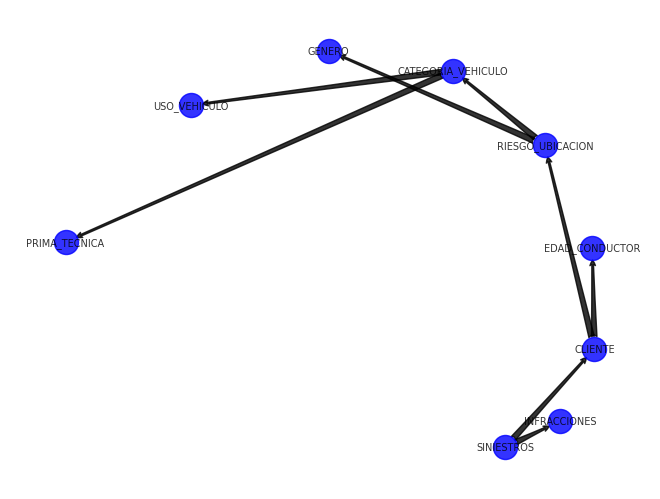

In [197]:
#Especificamos el nodo que debera ser el raiz utilizando el algoritmo de arboles porque el dataset tiene mas de 4 nodos o variables
est = TreeSearch(data, root_node='SINIESTROS')
#En la variable dag contendremos la red bayesiana obtenida por Aprendizaje Estructurado utilizando el estimador de tipo chow-liu
dag = est.estimate(estimator_type='chow-liu')
#Mostramos el DAG con un layout de tipo spiral
pos = nx.spiral_layout(dag)
nx.draw(dag, pos=pos, with_labels=True,node_color='b', font_size=7, arrowstyle='fancy', alpha=0.8)
#Guardamos el grafo DAG en un archivo .png que podemos visualizar y/o descargar
plt.savefig('plt.png')

In [198]:
print("Nodos: ", dag.nodes())
print("---------------")
print("Aristas: ", dag.edges())

print("--------" "\n")

print("Origen y destino de las Aristas")
print("-------------------------------" "\n")
nx.to_pandas_edgelist(dag)

Nodos:  ['SINIESTROS', 'INFRACCIONES', 'CLIENTE', 'EDAD_CONDUCTOR', 'RIESGO_UBICACION', 'CATEGORIA_VEHICULO', 'GENERO', 'USO_VEHICULO', 'PRIMA_TECNICA']
---------------
Aristas:  [('SINIESTROS', 'INFRACCIONES'), ('SINIESTROS', 'CLIENTE'), ('CLIENTE', 'EDAD_CONDUCTOR'), ('CLIENTE', 'RIESGO_UBICACION'), ('RIESGO_UBICACION', 'CATEGORIA_VEHICULO'), ('RIESGO_UBICACION', 'GENERO'), ('CATEGORIA_VEHICULO', 'USO_VEHICULO'), ('CATEGORIA_VEHICULO', 'PRIMA_TECNICA')]
--------

Origen y destino de las Aristas
-------------------------------



,source,target,weight
0,SINIESTROS,INFRACCIONES,None
1,SINIESTROS,CLIENTE,None
2,CLIENTE,EDAD_CONDUCTOR,None
3,CLIENTE,RIESGO_UBICACION,None
4,RIESGO_UBICACION,CATEGORIA_VEHICULO,None
5,RIESGO_UBICACION,GENERO,None
6,CATEGORIA_VEHICULO,USO_VEHICULO,None
7,CATEGORIA_VEHICULO,PRIMA_TECNICA,None


### **5.2. Red Bayesiana**

Devuelve la **Estimación de probabilidad condicional** basada en el atributo variable tiempo **(time)** como nodo raíz (lo obtiene desde el Dag generado en la variable **dag**)

In [199]:
model = BayesianNetwork(dag)
model.fit(data)
model.get_cpds()

[<TabularCPD representing P(SINIESTROS:2) at 0x7fdeeaa554b0>,
 <TabularCPD representing P(INFRACCIONES:2 | SINIESTROS:2) at 0x7fdef1930a60>,
 <TabularCPD representing P(CLIENTE:2 | SINIESTROS:2) at 0x7fdeeaa54550>,
 <TabularCPD representing P(EDAD_CONDUCTOR:2 | CLIENTE:2) at 0x7fdef1932410>,
 <TabularCPD representing P(RIESGO_UBICACION:2 | CLIENTE:2) at 0x7fdeeaa55090>,
 <TabularCPD representing P(CATEGORIA_VEHICULO:2 | RIESGO_UBICACION:2) at 0x7fdef1932650>,
 <TabularCPD representing P(GENERO:2 | RIESGO_UBICACION:2) at 0x7fdeeaa56fe0>,
 <TabularCPD representing P(USO_VEHICULO:2 | CATEGORIA_VEHICULO:2) at 0x7fdeeaa568f0>,
 <TabularCPD representing P(PRIMA_TECNICA:2 | CATEGORIA_VEHICULO:2) at 0x7fdef19319c0>]

### Cálculo de Inferencias

In [200]:
#la variable infer identifica el objeto que ejecutara el algoritmo del calculo de inferencias a partir de la eliminiacion de la variable
infer = VariableElimination(model)

In [201]:
#Cual es la probabilidad de que un adulto mujer tenga un vehiculo de alta gama
q = infer.query(variables=["CATEGORIA_VEHICULO"], evidence={"GENERO": 1, "EDAD_CONDUCTOR": 1}, joint=False)
for factor in q.values():
    print(factor)

+-----------------------+---------------------------+
| CATEGORIA_VEHICULO    |   phi(CATEGORIA_VEHICULO) |
+=======================+===========================+
| CATEGORIA_VEHICULO(0) |                    0.8812 |
+-----------------------+---------------------------+
| CATEGORIA_VEHICULO(1) |                    0.1188 |
+-----------------------+---------------------------+


In [202]:
#Cual es la probabilidad de que los hombres jovenes tengan alta cantidad de infracciones?
q = infer.query(variables=["INFRACCIONES"], evidence={"GENERO": 0, "EDAD_CONDUCTOR": 0}, joint=False)
for factor in q.values():
    print(factor)

+-----------------+---------------------+
| INFRACCIONES    |   phi(INFRACCIONES) |
+=================+=====================+
| INFRACCIONES(0) |              0.8302 |
+-----------------+---------------------+
| INFRACCIONES(1) |              0.1698 |
+-----------------+---------------------+


In [203]:
#Cual es la probabilidad de que una persona con edad adulta viva en un lugar de bajos riesgos?
q = infer.query(variables=["RIESGO_UBICACION"], evidence={"EDAD_CONDUCTOR": 1}, joint=False)
for factor in q.values():
    print(factor)

+---------------------+-------------------------+
| RIESGO_UBICACION    |   phi(RIESGO_UBICACION) |
+=====================+=========================+
| RIESGO_UBICACION(0) |                  0.7042 |
+---------------------+-------------------------+
| RIESGO_UBICACION(1) |                  0.2958 |
+---------------------+-------------------------+


In [204]:
#Cual es la probabilidad de que las mujeres adultas no tengan siniestros anteriores?
q = infer.query(variables=["SINIESTROS"], evidence={"GENERO": 1,"EDAD_CONDUCTOR": 1}, joint=False)
for factor in q.values():
    print(factor)

+---------------+-------------------+
| SINIESTROS    |   phi(SINIESTROS) |
+===============+===================+
| SINIESTROS(0) |            0.8359 |
+---------------+-------------------+
| SINIESTROS(1) |            0.1641 |
+---------------+-------------------+


In [205]:
#Cual es la probabilidad de tener clientes jovenes nuevos?
q = infer.query(variables=["EDAD_CONDUCTOR"] ,joint=False)
for factor in q.values():
    print(factor)

+-------------------+-----------------------+
| EDAD_CONDUCTOR    |   phi(EDAD_CONDUCTOR) |
+===================+=======================+
| EDAD_CONDUCTOR(0) |                0.0865 |
+-------------------+-----------------------+
| EDAD_CONDUCTOR(1) |                0.9135 |
+-------------------+-----------------------+
